<a href="https://colab.research.google.com/github/TanishqThuse/Sentimental_Analysis/blob/main/Mama_Earth_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT OUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-fine-food-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F18%2F2157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240215%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240215T093514Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7842ce9849dd6a91a3db7dece4ded51593f4c59fd8bf8e9f1296b02b524b5094e1cbfefe705e6173afd449875a8bda2eea0873e312afaf769d799cefdd08dd7367aa8e686a283426a6025265422bdc152272829177b28200dc305af558550dad3a92533f161c59c70618f57e7fe8e2085d7d2b70fc3922b17d7dc27834a4c13ea10aa140e0f8ce2cc8dbef898ac60e11417d0aec74f9aeae0b8454ca3a0d811bcfa8308387399eff798390f89b8b9acc13c36feb3b68931bd69be826349913bfa393439c8c7aca4927200243b5eb5afa5e3b456914b660428929e9a4b9256282b08c8b0fa581dab4e4af06a028e037e73abfe75807b34a3e0fdc7f056a036cad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 253873708 bytes downloaded
Downloaded and uncompressed: amazon-fine-food-reviews
Data source import complete.


In this project, we perform sentiment analysis on a dataset of approximately  31,000 product reviews from Mama Earth, a consumer products brand company. The goal is to understand customer feedback across various platforms, including e-commerce websites and social media, to identify common themes, sentiments, and areas for improvement. This analysis will inform product enhancements and customer service strategies to better meet customer needs. We employ natural language processing (NLP) techniques, specifically using the NLTK library, to process and analyze the textual data, extracting insights into customer sentiments towards Mama Earth's products.

# Step 0. Read in Data and NLTK Basics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [ ]:
# Read in data
df = pd.read_csv('/content/Reviews Data.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(31814, 16)
(500, 16)


In [ ]:
df.head()
#To see the coloums

,SKU,PRODUCT_NAME,PRICE,PRODUCT_CATEGORY,PACK_SIZE,REVIEW_COUNT,REVIEW_DATE,REVIEW_TIME,PRICE_RATING,QUALITY_RATING,VALUE_RATING,REVIEW_CONTENT,URL,DATE_OF_CREATION,LAST_UPDATED_DATE,STATES
0,8904417301922,Moisture Matte Longstay Lipstick - 2g | Citrus...,499.00,face,2g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://mamaearth.in/product/moisture-matte-lo...,2022-09-13,2022-09-19,Uttar Pradesh
1,8904417301915,Moisture Matte Longstay Lipstick - 2g | Berryl...,499.00,Other,2g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://mamaearth.in/product/moisture-matte-lo...,2022-09-13,2022-09-19,Arunachal Pradesh
2,8904417301908,Moisture Matte Longstay Lipstick -2g | Cherry...,499.00,face,2g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://mamaearth.in/product/moisture-matte-lo...,2022-09-13,2022-09-19,Karnataka
3,8904417301892,Moisture Matte Long Stay Lipstick - 2g | Pink ...,499.00,face,2g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://mamaearth.in/product/moisture-matte-lo...,2022-09-13,2022-09-19,Gujarat
4,8904417303377,Vitamin C Daily Glow Face Cream - 80 g - Pack ...,498.00,skin,80g,2.0,2022-09-13,18:33:56,5.0,0.0,0.0,Like,https://mamaearth.in/product/vitamin-c-daily-g...,2022-09-01,2022-09-12,Madhya Pradesh


In [ ]:
df.tail()
#the only reason i did df.tail was to see if there are any unique values other than 5 , 4 but sadly no

,SKU,PRODUCT_NAME,PRICE,PRODUCT_CATEGORY,PACK_SIZE,REVIEW_COUNT,REVIEW_DATE,REVIEW_TIME,PRICE_RATING,QUALITY_RATING,VALUE_RATING,REVIEW_CONTENT,URL,DATE_OF_CREATION,LAST_UPDATED_DATE,STATES
495,8904417300659,Coco Soft Bathing Bar for Babies with Coconut ...,249.00,skin,2*75g,14.0,2022-08-10,08:56:54,5.0,0.0,0.0,Osm,https://mamaearth.in/product/coco-soft-bathing...,2022-06-29,2022-08-31,Himachal Pradesh
496,8904417300659,Coco Soft Bathing Bar for Babies with Coconut ...,249.00,skin,2*75g,14.0,2022-08-03,17:36:58,5.0,0.0,0.0,This coco bar is very very moisturizing I real...,https://mamaearth.in/product/coco-soft-bathing...,2022-06-29,2022-08-31,Maharashtra
497,8904417300659,Coco Soft Bathing Bar for Babies with Coconut ...,249.00,skin,2*75g,14.0,2022-07-28,17:05:00,5.0,0.0,0.0,Good,https://mamaearth.in/product/coco-soft-bathing...,2022-06-29,2022-08-31,Maharashtra
498,8904417300659,Coco Soft Bathing Bar for Babies with Coconut ...,249.00,skin,2*75g,14.0,2022-07-19,13:01:22,5.0,0.0,0.0,"I really like this product l, it's really real...",https://mamaearth.in/product/coco-soft-bathing...,2022-06-29,2022-08-31,Punjab
499,8904417300659,Coco Soft Bathing Bar for Babies with Coconut ...,249.00,skin,2*75g,14.0,2022-07-15,16:16:56,5.0,0.0,0.0,Very super product for babies...now my baby wa...,https://mamaearth.in/product/coco-soft-bathing...,2022-06-29,2022-08-31,Arunachal Pradesh


Since there are 3 parametres in which we are given scores I will create 3 graphs as shown below


## Quick EDA

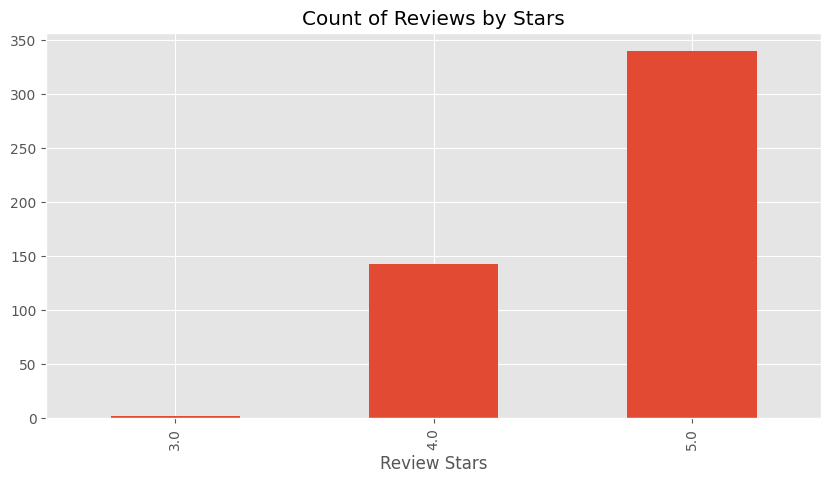

In [ ]:
ax = df['PRICE_RATING'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

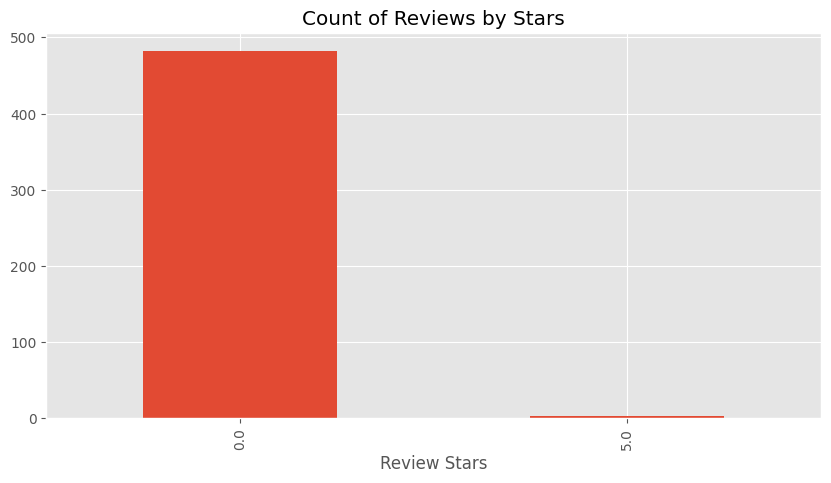

In [ ]:
ax = df['QUALITY_RATING'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

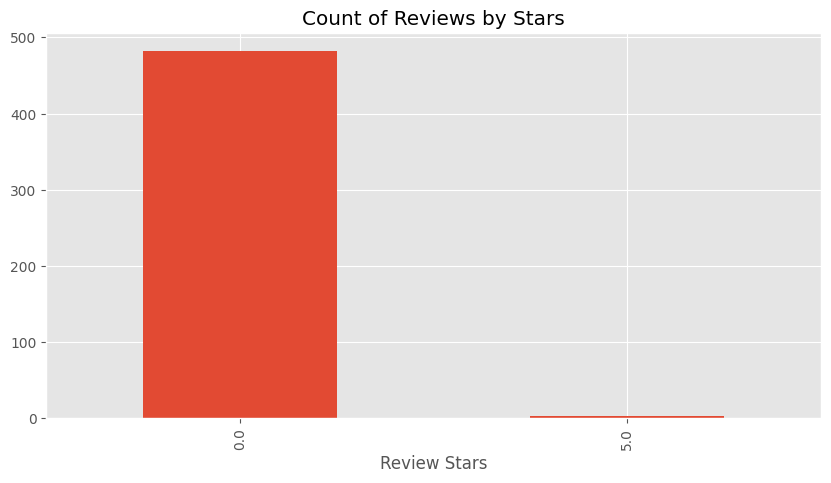

In [ ]:
ax = df['VALUE_RATING'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [ ]:
example = df['REVIEW_CONTENT'][50]
print(example)

It's my new daily cleanser, and it's gentle enough for almost all skin types. Excellent texture and result!! BUY IT TODAY AND SEE FOR YOURSELF! 


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['It', "'s", 'my', 'new', 'daily', 'cleanser', ',', 'and', 'it', "'s"]

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('It', 'PRP'),
 ("'s", 'VBZ'),
 ('my', 'PRP$'),
 ('new', 'JJ'),
 ('daily', 'JJ'),
 ('cleanser', 'NN'),
 (',', ','),
 ('and', 'CC'),
 ('it', 'PRP'),
 ("'s", 'VBZ')]

In [ ]:
 nltk.download('maxent_ne_chunker')
 nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
#What does the below mean and what is it for

In [ ]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'compound': 0.8164}

In [ ]:
# # Run the polarity score on the entire dataset
# res = {}
# for i, row in tqdm(df.iterrows(), total=len(df)):
#     text = row['REVIEW_CONTENT']
#     myid = row['SKU']
#     res[myid] = sia.polarity_scores(text)

#My 2nd attempt for making it better
# Running the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['REVIEW_CONTENT']
    # Ensure text is a string before encoding
    if isinstance(text, float):
        text = str(text)
    myid = row['SKU']
    res[myid] = sia.polarity_scores(text)
    #somehow it works : Logic = Change the 'text' to string using str to prevent if the value is not stiring(earlier it was float)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print(vaders.columns)
print(df.columns)
#The only reasonn i did this is to check if SKU exits and I am replacing it for id

Index(['Id', 'neg', 'neu', 'pos', 'compound'], dtype='object')
Index(['SKU', 'PRODUCT_NAME', 'PRICE', 'PRODUCT_CATEGORY', 'PACK_SIZE',
       'REVIEW_COUNT', 'REVIEW_DATE', 'REVIEW_TIME', 'PRICE_RATING',
       'QUALITY_RATING', 'VALUE_RATING', 'REVIEW_CONTENT', 'URL',
       'DATE_OF_CREATION', 'LAST_UPDATED_DATE', 'STATES'],
      dtype='object')


In [ ]:
# #I have doubt in this code fragment

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'SKU'})
vaders = vaders.merge(df, how='left')


In [ ]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound
0,8904417301922,0.0,1.000,0.000,0.0000
1,8904417301915,0.0,1.000,0.000,0.0000
2,8904417301908,0.0,1.000,0.000,0.0000
3,8904417301892,0.0,1.000,0.000,0.0000
4,8904417303377,0.0,0.444,0.556,0.3612


In [ ]:
#For Plot VADER Results :
#Since we have 3 types of scores Imma gonna draw 3 graphs

SyntaxError: invalid syntax (<ipython-input-50-88053431057b>, line 1)

## Plot VADER results

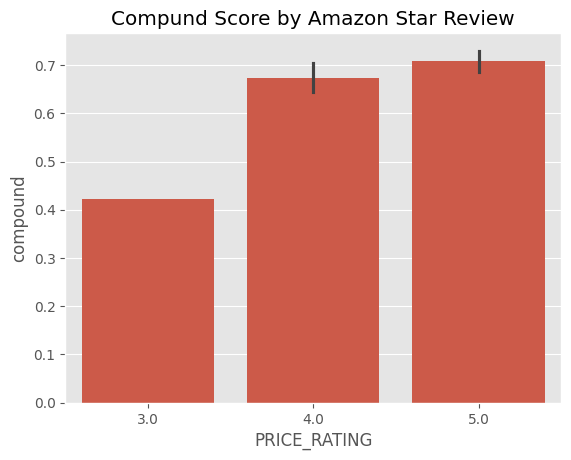

In [ ]:
ax = sns.barplot(data=vaders, x='PRICE_RATING', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

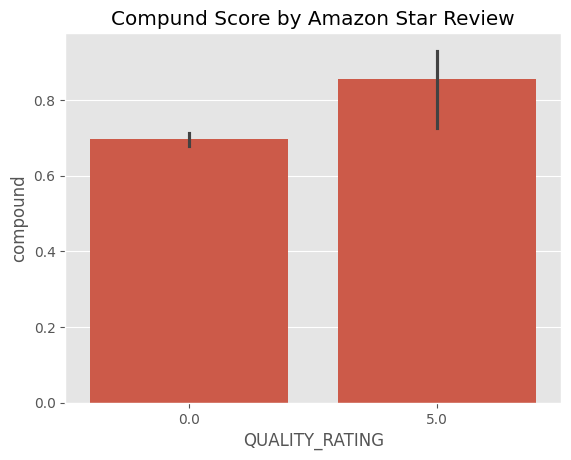

In [ ]:
ax = sns.barplot(data=vaders, x='QUALITY_RATING', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

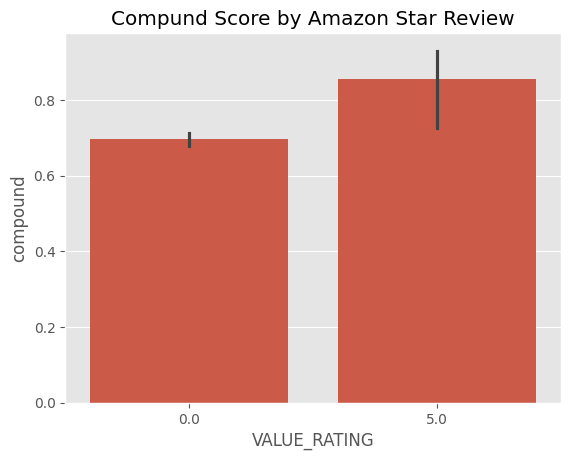

In [ ]:
ax = sns.barplot(data=vaders, x='VALUE_RATING', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

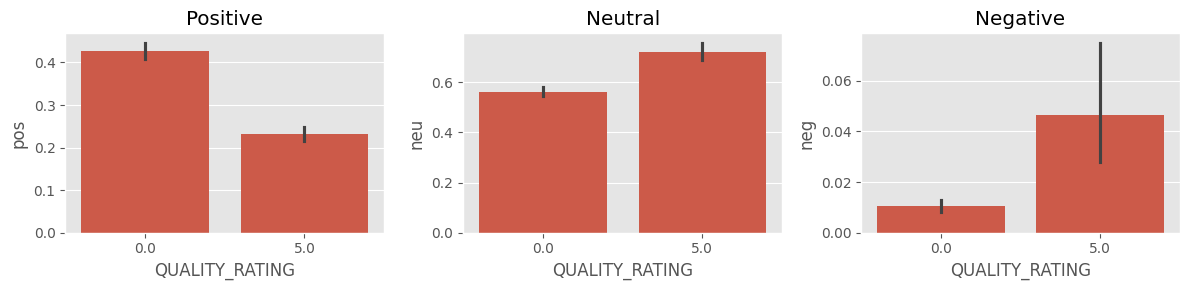

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='QUALITY_RATING', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='QUALITY_RATING', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='QUALITY_RATING', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

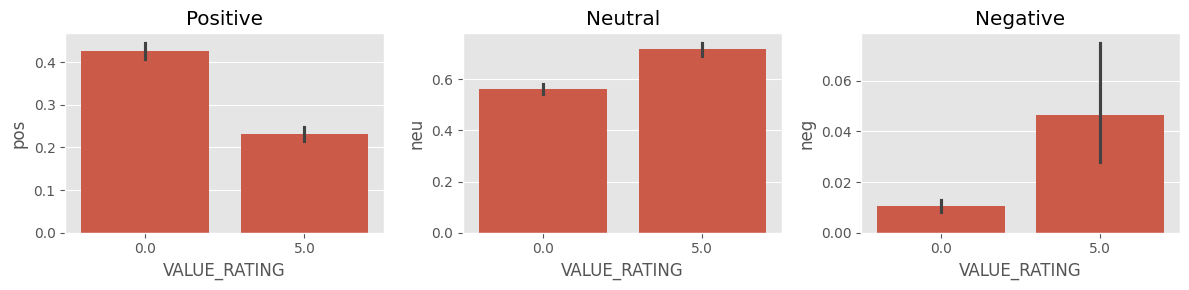

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='VALUE_RATING', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='VALUE_RATING', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='VALUE_RATING', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

) missing from current font.
  plt.tight_layout()
<ipython-input-77-f7d3033393df>:10: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
<ipython-input-77-f7d3033393df>:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


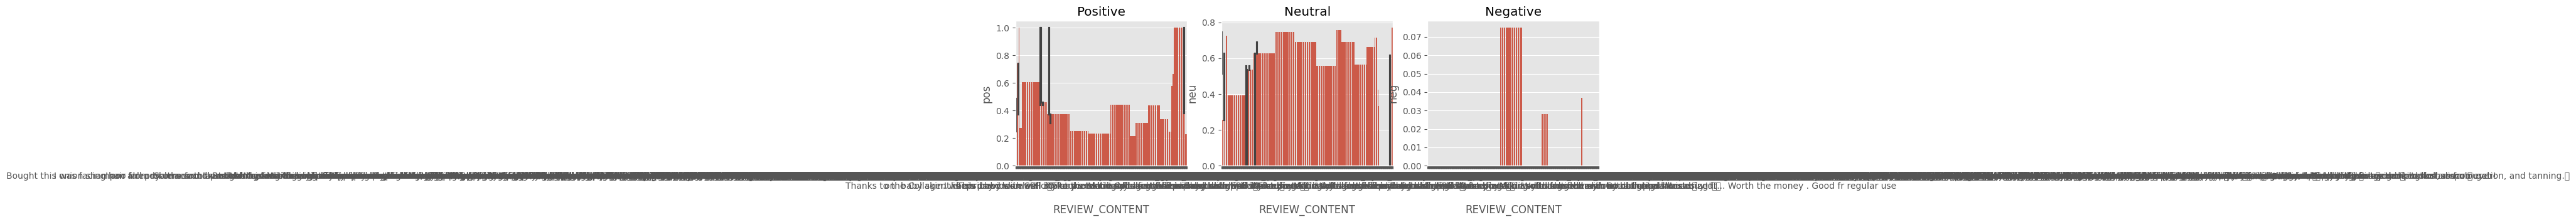

In [77]:
##FOR SOME UNKNOWN REASONS THE OUTPUT IS NOT DISLPLAYED PROPERLY BUT OK, we'll see about that

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='REVIEW_CONTENT', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='REVIEW_CONTENT', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='REVIEW_CONTENT', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# # import matplotlib.pyplot as plt
# # import seaborn as sns

# # Define a custom font
# plt.rcParams['font.family'] = 'Arial'  # Replace with the font name

# # Create the plot
# fig, axs = plt.subplots(1,  3, figsize=(12,  3))
# sns.barplot(data=vaders, x='REVIEW_CONTENT', y='pos', ax=axs[0])
# sns.barplot(data=vaders, x='REVIEW_CONTENT', y='neu', ax=axs[1])
# sns.barplot(data=vaders, x='REVIEW_CONTENT', y='neg', ax=axs[2])
# axs[0].set_title('Positive')
# axs[1].set_title('Neutral')
# axs[2].set_title('Negative')
# plt.tight_layout()
# plt.show()

##import matplotlib.pyplot as plt
##import seaborn as sns

# # Set font family
# plt.rcParams['font.family'] = 'Times New Roman'

# # Define the subplots
# fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# # Create the bar plots
# sns.barplot(data=vaders, x='REVIEW_CONTENT', y='pos', ax=axs[0])
# sns.barplot(data=vaders, x='REVIEW_CONTENT', y='neu', ax=axs[1])
# sns.barplot(data=vaders, x='REVIEW_CONTENT', y='neg', ax=axs[2])

# # Set titles for each subplot
# axs[0].set_title('Positive')
# axs[1].set_title('Neutral')
# axs[2].set_title('Negative')

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()


# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [64]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [65]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [66]:
# VADER results on example
print(example)
sia.polarity_scores(example)

It's my new daily cleanser, and it's gentle enough for almost all skin types. Excellent texture and result!! BUY IT TODAY AND SEE FOR YOURSELF! 


{'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'compound': 0.8164}

In [67]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0016680153, 'roberta_neu': 0.02011515, 'roberta_pos': 0.97821677}


In [68]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [72]:
# res = {}
# for i, row in tqdm(df.iterrows(), total=len(df)):
#     try:
#         text = row['REVIEW_CONTENT']
#         myid = row['SKU']
#         vader_result = sia.polarity_scores(text)
#         vader_result_rename = {}
#         for key, value in vader_result.items():
#             vader_result_rename[f"vader_{key}"] = value
#         roberta_result = polarity_scores_roberta(text)
#         both = {**vader_result_rename, **roberta_result}
#         res[myid] = both
#     except RuntimeError:
#         print(f'Broke for id {myid}')

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['REVIEW_CONTENT']
        # Ensure text is a string before passing to polarity_scores
        if isinstance(text, float):
            text = str(text)
        myid = row['SKU']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [73]:
#This cell is not working

results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

## Compare Scores between models

In [74]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')

# Step 3. Combine and compare

KeyError: 'PRICE_RATING'

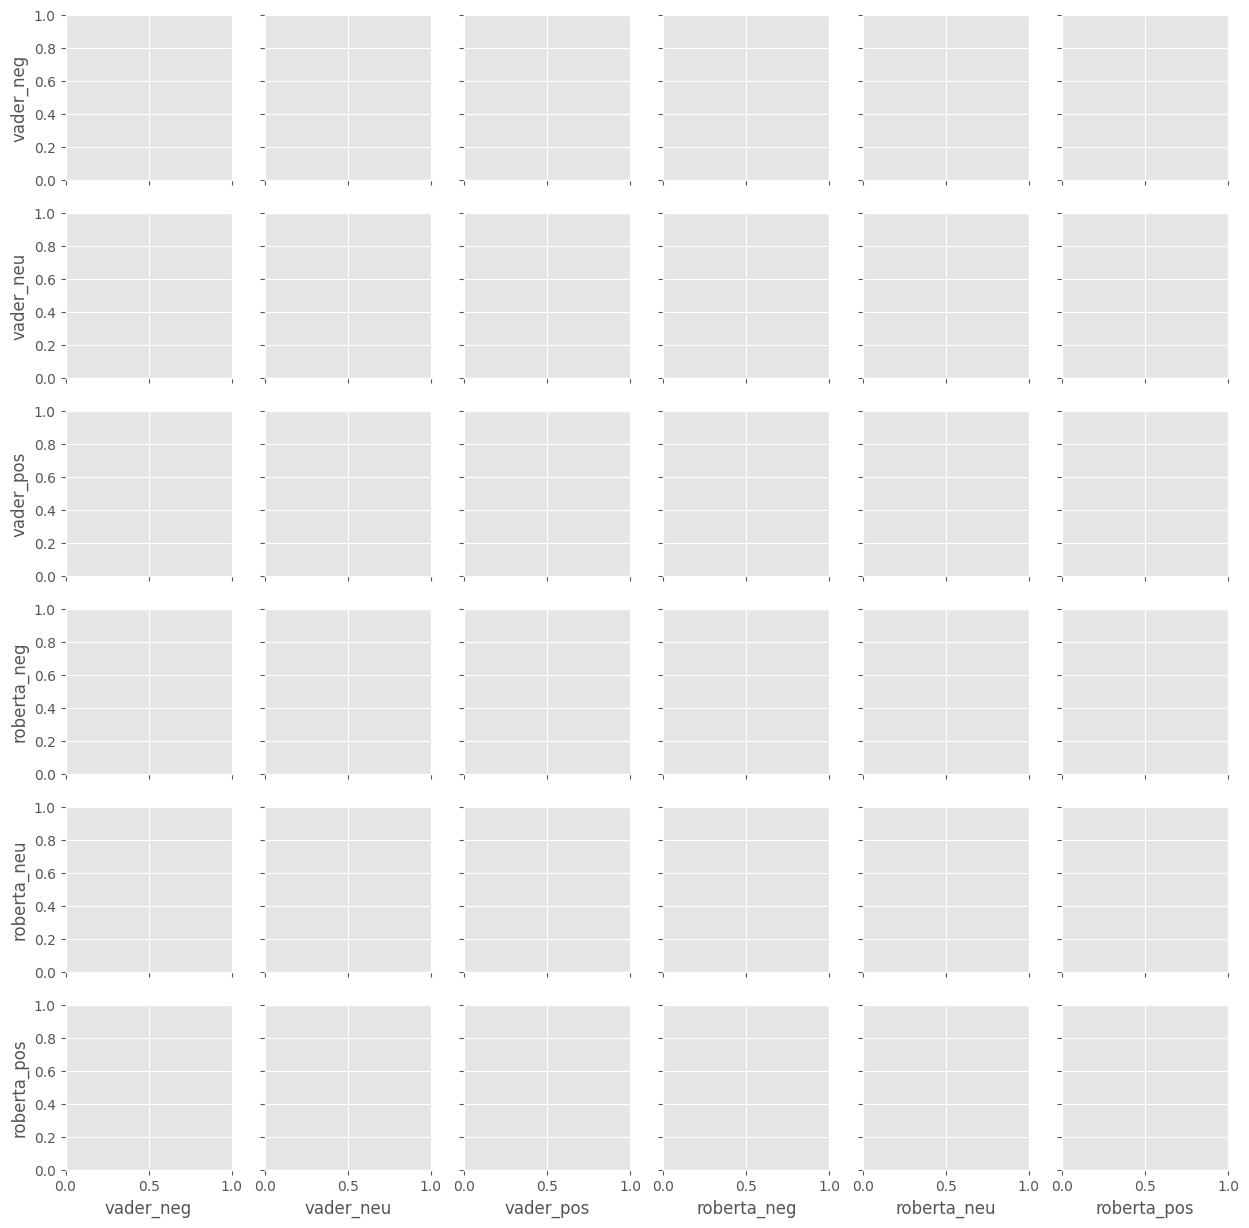

In [76]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='PRICE_RATING',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [82]:
results_df.query('QUALITY_RATING == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

UndefinedVariableError: name 'QUALITY_RATING' is not defined

In [81]:
results_df.query('PRICE_RATING == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

UndefinedVariableError: name 'PRICE_RATING' is not defined

In [ ]:
# nevative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
#sent_pipeline('I love sentiment analysis!')

In [ ]:
#sent_pipeline('Make sure to like and subscribe!')

In [ ]:
#sent_pipeline('booo')

# The End